In [1]:
import sys
import os
import json
import glob
import h5py

import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('assets_psychophysics')
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

sys.path.append('assets_datasets')
import util_stimuli
importlib.reload(util_stimuli)


<module 'util_stimuli' from '/om2/user/msaddler/pitchnet/assets_datasets/util_stimuli.py'>

In [ ]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[70.0],
        'cohc':1.0,
        'bandwidth_scale_factor':1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}


# sr = 32000
# t = np.arange(0, 0.150, 1/sr)
# signal = np.zeros_like(t)
# noise = np.random.randn(signal.shape[0])
# f0 = 200
# phase_mode = 'sine'

# freq_list = f0*np.arange(1, 60)
# if phase_mode == 'alt':
#     phase_list = np.pi/2 * np.ones(len(freq_list))
#     phase_list[::2] = 0
# else:
#     phase_list = np.zeros(len(freq_list))
# for freq, phase in zip(freq_list, phase_list):
#     if freq < sr/2:
#         signal = signal + np.sin(2*np.pi*freq*t + phase)

# snr = 12
# dBSPL = 60
# noise = np.random.randn(noise.shape[0])

# y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
#                                           rms_out=20e-6*np.power(10, dBSPL/20))

# fn = '/om/user/msaddler/data_pitchnet/oxenham2004/Oxenham2004_transposedTones_f0_080to320Hz/Oxenham2004_transposedTones_f0_080to320Hz.hdf5'
# f = h5py.File(fn, 'r')
# y = f['stimuli/signal'][3999]
# sr = f['sr'][0]
# f.close()

fn = '/om/scratch/Wed/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_sr32000_v08_0000000-0021000.hdf5'
f = h5py.File(fn, 'r')
IDX = 14184#np.random.randint(f['stimuli/signal'].shape[0])
signal = f['stimuli/signal'][IDX]
noise = f['stimuli/noise'][IDX]
f0 = f['nopad_f0_mean'][IDX]
print(IDX, f0)
sr = f['sr'][0]
f.close()

snr = 10
dBSPL = 60

y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))

ipd.display(ipd.Audio(y, rate=sr))


In [ ]:
out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)


In [ ]:
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

figsize=(8, 5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.05,
    'hspace': 0.05,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 6],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)

util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
    ax_idx_nervegram=4,
    ax_idx_spectrum=3,
    ax_idx_excitation=5,
    ax_idx_waveform=1,
    nervegram=out_dict['meanrates'],
    nervegram_sr=out_dict['meanrates_fs'],
    waveform=out_dict['pin'],
    waveform_sr=out_dict['pin_fs'],
    cfs=out_dict['cf_list'],
    fontsize_title=12,
    fontsize_labels=12,
    fontsize_legend=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    plot_kwargs={'lw':2},
    limits_buffer=0.2,
    nxticks=6, 
    nyticks=6,
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)



In [ ]:
figsize = (1.8, 0.6)
tmin = 0.075
tmax = 0.121
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=signal,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_signal.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=noise,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


figsize=(2.4, 1.6)
nrows=1
ncols=1
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
                                  ax_idx_nervegram=0,
                                  ax_idx_spectrum=None,
                                  ax_idx_excitation=None,
                                  ax_idx_waveform=None,
                                  nervegram=out_dict['meanrates'],
                                  nervegram_sr=out_dict['meanrates_fs'],
                                  waveform=out_dict['pin'],
                                  waveform_sr=out_dict['pin_fs'],
                                  cfs=out_dict['cf_list'],
                                  fontsize_title=12,
                                  fontsize_labels=12,
                                  fontsize_legend=12,
                                  fontsize_ticks=12,
                                  fontweight_labels=None,
                                  plot_kwargs={'lw':2},
                                  limits_buffer=0.2,
                                  nxticks=0, 
                                  nyticks=0,
                                  spines_to_hide_spectrum=[],
                                  spines_to_hide_excitation=[],
                                  spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])
ax_arr.set_xlabel(None)
ax_arr.set_ylabel(None)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_signal_in_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


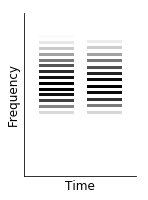

In [47]:
import stimuli_generate_BernsteinOxenhamFixedFilter
import matplotlib.cm


def map_level_to_color(level,
                       level_min=None,
                       level_max=None,
                       cmap_name='Greys',
                       cmap_n=None):
    '''
    '''
    level = np.array(level)
    if level_min is not None:
        level[level < level_min] = level_min
    if level_max is not None:
        level[level > level_max] = level_max
    level_normalized = level - np.min(level)
    level_normalized = level_normalized / np.max(level_normalized)
    cmap = matplotlib.cm.get_cmap(cmap_name, cmap_n)
    color = cmap(level_normalized)
    return color


def schematic_spectrogram(ax, times, freqs,
                          colors='k',
                          kwargs_plot_update={}):
    '''
    '''
    kwargs_plot = {
        'lw': 3,
        'ls': '-',
        'marker': '',
    }
    kwargs_plot.update(kwargs_plot_update)
    if not len(colors) == len(freqs):
        assert len(colors) == 1
        colors = [colors] * len(freqs)
    for f, c in zip(freqs, colors):
        kwargs_plot['color'] = c
        ax.plot(times, np.ones_like(times)*f, **kwargs_plot)
    return ax


fs = 32000
highpass_filter_cutoff = 2.5e3
lowpass_filter_cutoff = 3.5e3
filter_order = 4

base_f0 = 300
lh = 10
threshold_dBSPL=33.3
component_dBSL=15.0


baseline_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.get_bandpass_filter_frequency_response(
    highpass_filter_cutoff,
    lowpass_filter_cutoff,
    fs=fs, order=filter_order)
desired_fl = base_f0 * lh
desired_fl_gain_in_dB = -1 * component_dBSL
fixed_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.shift_bandpass_filter_frequency_response(
    desired_fl, desired_fl_gain_in_dB, fs=fs, unshifted_passband=None,
    frequency_response_in_dB=baseline_freq_response)


f0_1 = base_f0 * 0.95
f0_2 = base_f0 * 1.05
freqs_1 = np.arange(f0_1, fs/2, f0_1)
freqs_2 = np.arange(f0_2, fs/2, f0_2)
level_min = -component_dBSL-1
colors_1 = map_level_to_color(fixed_freq_response(freqs_1), level_min=level_min)
colors_2 = map_level_to_color(fixed_freq_response(freqs_2), level_min=level_min)

dur = 1
gap = 0.5


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 3))

times = np.array([0, dur])
ax = schematic_spectrogram(ax, times, freqs_1, colors=colors_1)
# ax = schematic_spectrogram(ax, times, np.array([lh*f0_1]), colors='r', kwargs_plot_update={'lw':0.5})

times = times + gap + dur
ax = schematic_spectrogram(ax, times, freqs_2, colors=colors_2)
# ax = schematic_spectrogram(ax, times, np.array([lh*f0_2]), colors='r', kwargs_plot_update={'lw':0.5})

limits_buffer = 0.2
[xb, yb, dxb, dyb] = ax.dataLim.bounds
limits_x = [xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb]

ax = util_figures.format_axes(ax,
    str_xlabel='Time',
    str_ylabel='Frequency',
    fontsize_labels=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    xscale='linear',
    yscale='linear',
    xlimits=limits_x,
    ylimits=[0, 8000],
    xticks=[],
    yticks=[],
    xticks_minor=None,
    yticks_minor=None,
    xticklabels=None,
    yticklabels=None,
    spines_to_hide=['right', 'top'],
    major_tick_params_kwargs_update={},
    minor_tick_params_kwargs_update={})

plt.show()


In [ ]:
import os
import sys
import json
import copy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import importlib
sys.path.append('assets_psychophysics')
import util_figures_cnn
importlib.reload(util_figures_cnn)


# brain_arch_fn = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_{:04.0f}/brain_arch.json'
# for ARCH_N in [0, 9, 19, 29]:
brain_arch_fn = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04.0f}/brain_arch.json'
for ARCH_N in [302] + np.random.randint(0, 302, 5).tolist():
    print(ARCH_N)
    layer_list = util_figures_cnn.process_cnn_layer_list(brain_arch_fn.format(ARCH_N))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
    ax = util_figures_cnn.draw_cnn_from_layer_list(ax, layer_list,
                             scaling_w='log2',
                             scaling_h='log2',
                             scaling_n='log2',
                             scaling_kernel='log2',
                             input_image=np.squeeze(out_dict['meanrates']))
    
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    fig_factor = 6
    fig.set_size_inches(dxb/fig_factor, dyb/fig_factor)

    plt.show()
